In [31]:
import matplotlib.pyplot as plt

def plot_pid_chart(lines: list[str]):
    # Parse values from dataset
    targets, angles, errors, outputs, times = [], [], [], [], []

    for line in lines:
        parts = line.strip().split(";")
        if len(parts) == 4:
            t, a, e, o = map(float, parts)
            targets.append(t)
            angles.append(a)
            errors.append(e)
            outputs.append(o)
        elif len(parts) == 5:
            t, a, e, o, ms = map(float, parts)
            targets.append(t)
            angles.append(a)
            errors.append(e)
            outputs.append(o)
            times.append(ms)

    # --- Time axis handling ---
    if times:
        # Convert milliseconds to seconds, normalize so first = 0
        start_time = times[0]
        time = [(t - start_time) / 1000.0 for t in times]
        time_label = "Time [s]"
    else:
        # Fallback: use index
        time = list(range(len(targets)))
        time_label = "Time step"

    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Left Y axis (Target, Angle, Error)
    ax1.plot(time, targets, '-', label='Target', color='gray', linewidth=1.5)
    ax1.plot(time, angles, label='Current Angle', color='blue', linewidth=2)
    ax1.plot(time, errors, label='Error', color='red', linewidth=1.5)
    ax1.set_xlabel(time_label)
    ax1.set_ylabel('Angle [°] / Error [°]')
    ax1.legend(loc='upper left')
    ax1.grid(True, linestyle='--', alpha=0.6)

    # Reference lines
    ax1.axhline(0, color='black', linewidth=2.5, linestyle='-')
    ax1.axhline(75, color='gray', linewidth=1.5, linestyle='--')
    ax1.axhline(65, color='gray', linewidth=1.5, linestyle='--')

    # --- Crossing detection ---
    def find_crossings(angle_list, target_list):
        up_cross = None
        down_cross = None
        for i in range(1, len(angle_list)):
            if angle_list[i-1] < target_list[i-1] and angle_list[i] >= target_list[i]:
                up_cross = i
            if angle_list[i-1] > target_list[i-1] and angle_list[i] <= target_list[i]:
                down_cross = i
        return up_cross, down_cross

    up_cross, down_cross = find_crossings(angles, targets)

    if up_cross is not None:
        ax1.axvline(time[up_cross], color='black', linestyle='--', linewidth=1.8, label='Cross Up')
    if down_cross is not None:
        ax1.axvline(time[down_cross], color='black', linestyle='--', linewidth=1.8, label='Cross Down')

    # Max angle line
    if angles:
        max_index = angles.index(max(angles))
        ax1.axvline(time[max_index], color='black', linestyle='--', linewidth=1.8, label='Max Angle')

    # Right Y axis (Output)
    ax2 = ax1.twinx()
    ax2.plot(time, outputs, label='Output (ms for valve opening)', color='orange', linewidth=2)
    ax2.set_ylabel('Output [ms]')
    ax2.legend(loc='upper right')

    plt.title('PID Controller Response (Valve Control)')
    plt.tight_layout()
    plt.show()

# PID control algorithm test #1
system configuration:
- tube length: 9 inch
- 3/4 inch sleeve diameter
- pressure of air: 60psi
- proportional gain: 1.2
- integral gain: 0.35
- derivative gain: 0.3
- tolerance: +- 5deg
- calculation of PID not stopped when in tolerance

After test:
Algorithm got to correct angle however as it got to the target and into tolerance it started to drift away fast. In next test, algorithm calculation should be disabled and reseted until it gets from tolerance. Also longer muscle should be used so whole operating radius can be utilized (0deg to 90 deg).

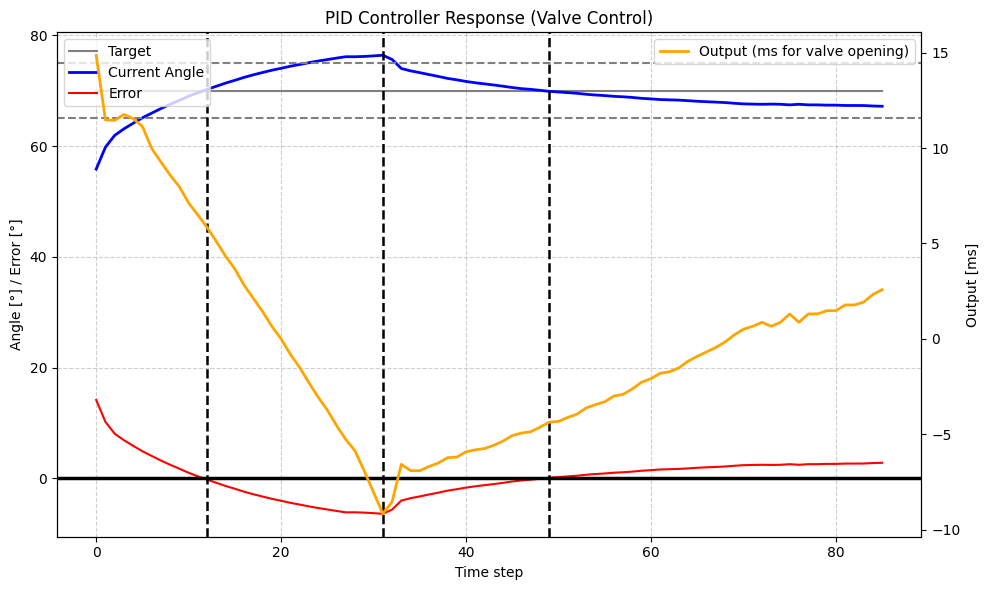

In [32]:
with open("pid-tests/transformed-data/pid-test-1.txt", "r") as f:
    lines = [line.strip() for line in f if line.strip() and not line.startswith("#")]
    plot_pid_chart(lines)

# PID control algorithm test #2
system configuration:
- tube length: 9 1/2 inch
- 3/4 inch sleeve diameter
- pressure of air: 60psi
- proportional gain: 1,2
- integral gain: 0,35
- derivative gain: 0,5
- tolerance: +- 5deg

Before test:
new tweaks: Control muscle and calculations of PID are now stopped when in tolerance. Minimal open valve time dropped from 50ms to 20ms.

After test:
Hold up for a while then started to go back again

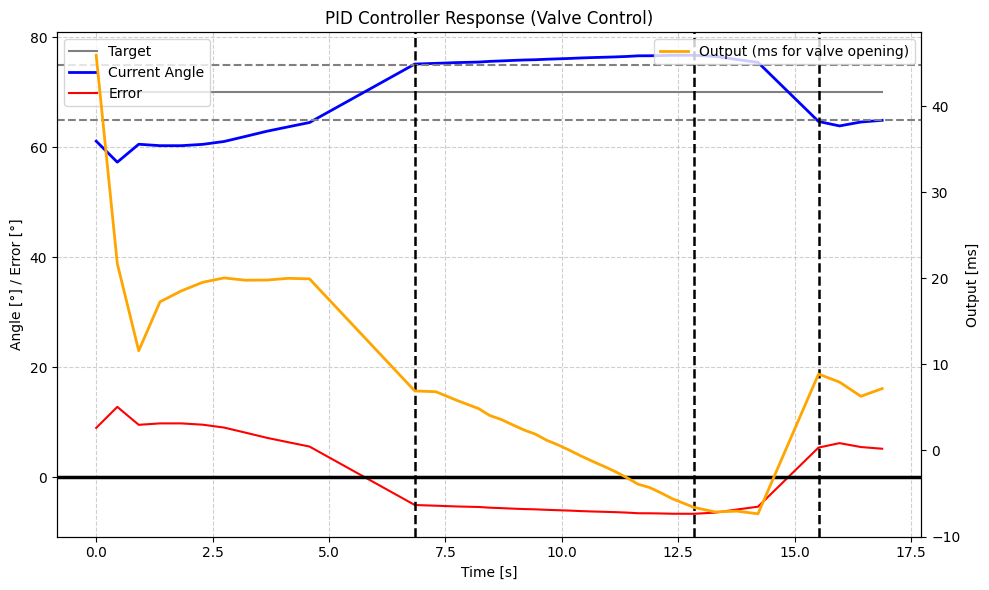

In [33]:
with open("pid-tests/transformed-data/pid-test-2.txt", "r") as f:
    lines = [line.strip() for line in f if line.strip() and not line.startswith("#")]
    plot_pid_chart(lines)

# PID control algorithm test #3
system configuration:
- tube length: 9 1/2 inch
- 3/4 inch sleeve diameter
- pressure of air: 60psi
- proportional gain: 1,2
- integral gain: 0,25
- derivative gain: 0,7
- tolerance: +- 5deg
- length: 30s

Before test:
new tweaks: Longer running time from 20s to 30s. Minimal open valve time decreased from 20ms to 10ms.

After test:
Sleeve holding under clamp released and that caused loss of control and almost poped.

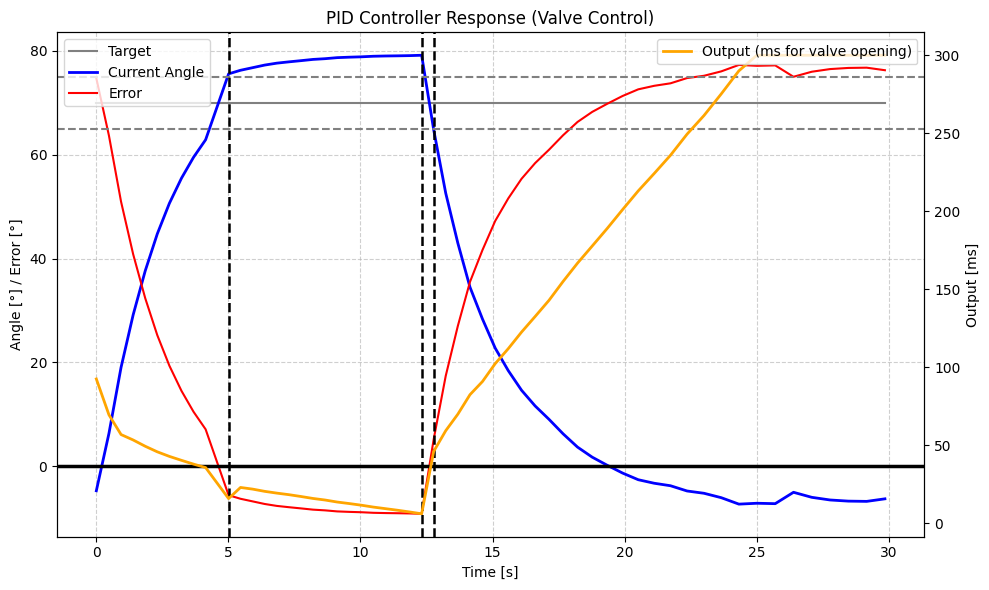

In [34]:
with open("pid-tests/transformed-data/pid-test-3.txt", "r") as f:
    lines = [line.strip() for line in f if line.strip() and not line.startswith("#")]
    plot_pid_chart(lines)

# PID control algorithm test #4
system configuration:
- tube length: 9 1/2 inch
- 3/4 inch sleeve diameter
- pressure of air: 60psi
- proportional gain: 0.9
- integral gain: 0.08
- derivative gain: 1.2
- tolerance: +- 5deg
- length: 20s

Before test:
new tweaks: 

After test:
